In [12]:
%matplotlib inline
import loader
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
file = '2012-Consolidated-stripped.csv'

In [13]:
def reservoir_sample(iterator, k):
    """
    Basic reservoir sample. Takes a target sample amount
    """
    # fill the reservoir to start
    iterator = iter(iterator)
    result = [next(iterator) for _ in range(k)]
    n = k
    for item in iterator:
        n += 1
        s = random.randint(0, n)
        if s < k:
            result[s] = item
    return result


def get_sample_size(len1, len2, percent):
    return int(min(len1, len2) * percent)

In [14]:
reload(loader)
rows = loader.load_raw(file)

In [15]:
# split dataset by chronic / not_chronic
chron = []
notchron = []

for pid in rows:
    person = rows[pid]
    person_data = person.info
    chron_bool = False
    for code in person.info:
        if 'chronic_'in code and not chron_bool:
                if person_data[code] is 1:
                    chron_bool = True
                elif person_data[code] is -9 or person_data[code] is -8 or person_data[code] is -7:
                    rows[pid].chronic = -1
            
    if chron_bool:
        chron.append(pid)
    else:
        notchron.append(pid)

In [16]:
# sample helpers
def sample_two(l1, l2, pct):
    ssize = get_sample_size(len(l1), len(l2), pct)
    s1 = reservoir_sample(l1, ssize)
    s2 = reservoir_sample(l2, ssize)
    return s1, s2

def sample_one(single, pct):
    ssize = get_sample_size(len(single), sys.maxint, pct)
    sample = reservoir_sample(single, ssize)
    return sample

def get_spending(id_list, rows):
    return [rows[pid].info['spending_dist_total'] for pid in id_list]

def get_subsidized(id_list, rows):
    return [rows[pid].info['spending_pay_medicaid'] + rows[pid].info['spending_pay_medicare'] for pid in id_list]

In [17]:
# create samples of chronic / not chronic
# schron, snotchron = sample_two(chron, notchron, 0.7)

# use all survey data
schron, snotchron = chron, notchron

In [18]:
# get average total spending for both groups
schron_spend = get_spending(schron, rows)
snotchron_spend = get_spending(snotchron, rows)
print 'chronic total spending', np.average(schron_spend), np.std(schron_spend)
print 'not chronic total spending', np.average(snotchron_spend), np.std(snotchron_spend)

chronic total spending 6394.5384354 15795.9605553
not chronic total spending 1441.82931454 8969.17501701


In [19]:
# get average subsidized spending
schron_sspend = get_subsidized(schron, rows)
snotchron_sspend = get_subsidized(snotchron, rows)
print 'chronic sub spending', np.average(schron_sspend), np.std(schron_sspend)
print 'not chronic sub spending', np.average(snotchron_sspend), np.std(snotchron_sspend)

chronic sub spending 2948.86454156 10613.3649614
not chronic sub spending 385.618235027 4139.18375232


In [20]:
# get total visits
schron_office = [rows[pid].info['service_office'] for pid in schron]
snotchron_office = [rows[pid].info['service_office'] for pid in snotchron]

# get cost per visit
schron_cpv = [rows[pid].info['spending_dist_office']/rows[pid].info['service_office'] for pid in schron if rows[pid].info['service_office']>0]
snotchron_cpv = [rows[pid].info['spending_dist_office']/rows[pid].info['service_office'] for pid in snotchron if rows[pid].info['service_office']>0]

In [21]:
print 'chronic office visits', np.average(schron_office), np.std(schron_office)
print 'not chronic office visits', np.average(snotchron_office), np.std(snotchron_office)

print 'chronic cost per visit', np.average(schron_cpv), np.std(schron_cpv)
print 'not chronic cost per visit', np.average(snotchron_cpv), np.std(snotchron_cpv)

chronic office visits 6.40875416299 11.6826967876
not chronic office visits 2.05341906764 5.12422962323
chronic cost per visit 3.96463822848 34.1270496411
not chronic cost per visit 1.52441941208 16.8581873787


In [22]:
# split dataset between chronic conditions
hbp = []
coronary = []
myocardial = []
stroke = []
diabetes = []
asthma = []
arthritis = []
cancer = []

hbp2 = []
multiple = []

diseases = {
    'chronic_hbp': hbp, 
    'chronic_coronary': coronary, 
    'chronic_myocardial': myocardial, 
    'chronic_stroke': stroke,
    'chronic_diabetes': diabetes,
    'chronic_asthma': asthma,
    'chronic_arthritis': arthritis, 
    'chronic_cancer': cancer
}

for pid in rows:
    person = rows[pid]
    person_data = person.info
    has_chronic = False
    for code in person.info:
        if 'chronic_hbp2' in code and person_data[code] is 1:
            hbp2.append(pid)
            continue
        if code in diseases and person_data[code] is 1: 
            diseases[code].append(pid)
            if not has_chronic:
                has_chronic = True
            else:
                multiple.append(pid)
                

# This boolean controls whether the multiple condition group is mutually exclusive from individual
separate = False
if (separate):
    # get people who only have that condition
    set_multiple = set(multiple)
    for disease in diseases:
        setify = set(diseases[disease])
        diseases[disease] = list(setify.difference(set_multiple))

    # get people who only have hbp and who were diagnosed twice
    set_hbp = set(hbp)
    set_hbp2 = set(hbp2)
    hbp2 = list(set_hbp.intersection(set_hbp2))   

In [23]:
# create sub samples of each condition
# shbp = sample_one(hbp, 0.7)
# scoronary = sample_one(coronary, 0.7)
# smyocardial = sample_one(myocardial, 0.7)
# sstroke = sample_one(stroke, 0.7)
# sdiabetes = sample_one(diabetes, 0.7)
# sasthma = sample_one(asthma, 0.7)
# sarthritis = sample_one(arthritis, 0.7)
# scancer = sample_one(cancer, 0.7)

# shbp2 = sample_one(hbp2, 0.7)
# smultiple = sample_one(multiple, 0.7)

# use all survey data
shbp = hbp
scoronary = coronary
smyocardial = myocardial
sstroke = stroke
sdiabetes = diabetes
sasthma = asthma
sarthritis = arthritis
scancer = cancer

shbp2 = hbp2
smultiple = multiple

In [25]:
# get subsidized spending for each condition (filtering out multiple)
shbp_ssp = get_subsidized(shbp, rows)
scoronary_ssp = get_subsidized(scoronary, rows)
smyocardial_ssp = get_subsidized(smyocardial, rows)
sstroke_ssp = get_subsidized(sstroke, rows)
sdiabetes_ssp = get_subsidized(sdiabetes, rows)
sasthma_ssp = get_subsidized(sasthma, rows)
sarthritis_ssp = get_subsidized(sarthritis, rows)
scancer_ssp = get_subsidized(scancer, rows)

shbp2_ssp = get_subsidized(shbp2, rows)
smultiple_ssp = get_subsidized(smultiple, rows)

print 'hbp', np.average(shbp_ssp)
print 'coronary', np.average(scoronary_ssp)
print 'myocardial', np.average(smyocardial_ssp)
print 'stroke', np.average(sstroke_ssp)
print 'diabetes', np.average(sdiabetes_ssp)
print 'asthma', np.average(sasthma_ssp)
print 'arthritis', np.average(sarthritis_ssp)
print 'cancer', np.average(scancer_ssp)

print 'hbp2', np.average(shbp2_ssp)
print 'multiple', np.average(smultiple_ssp)

hbp 3727.72606592
coronary 8392.54059985
myocardial 9403.9047619
stroke 9820.12734864
diabetes 5574.10178117
asthma 2519.49275362
arthritis 4665.05198777
cancer 5165.43870403
hbp2 4121.05126074
multiple 6841.06944108


In [27]:
all_s_sp = shbp_ssp + scoronary_ssp + smyocardial_ssp + sstroke_ssp + sdiabetes_ssp + sasthma_ssp + sarthritis_ssp + scancer_ssp
avg_all_s_sp = np.average(all_s_sp)
print 'diabetes patients spent', 100*(np.average(sdiabetes_ssp) - avg_all_s_sp)/avg_all_s_sp, '% more than average'

 diabetes patients spent 17.8739184081 % more than average


In [28]:
cared, uncared = [], []
for pid in sdiabetes:
    person = rows[pid]
    care = 0
    if ('diabetes_a1c' in person.info and person.info['diabetes_a1c']>0):
        care += 1
    if ('diabetes_foot' in person.info and person.info['diabetes_foot'] > 0):
        care += 1
    if ('diabetes_eye' in person.info and person.info['diabetes_eye'] > 0):
        care += 1
    if ('diabetes_cholest' in person.info and person.info['diabetes_cholest'] > 0):
        care += 1
    if (care <= 1):
        uncared.append(pid)
    else:
        cared.append(pid)

In [29]:
print len(cared), len(uncared)

2261 490


In [25]:
# get samples for cared and uncared groups
ssize = get_sample_size(len(cared), len(uncared), 0.7)
scared = reservoir_sample(cared, ssize)
suncared = reservoir_sample(uncared, ssize)

In [26]:
cared_cost = [rows[pid].info['spending_pay_medicaid']+rows[pid].info['spending_pay_medicare'] for pid in scared]
uncared_cost = [rows[pid].info['spending_pay_medicaid']+rows[pid].info['spending_pay_medicare'] for pid in suncared]

In [27]:
print np.average(uncared_cost), np.average(cared_cost)

6023.41702128 5533.68085106


In [28]:
# age breakdown for cared and uncared groups
cared_young, cared_mid, cared_old = [], [], []
uncared_young, uncared_mid, uncared_old = [], [], []
for pid in cared:
    person = rows[pid]
    if person.info['demo_age']>=65:
        cared_old.append(pid)
    elif person.info['demo_age']>=45:
        cared_mid.append(pid)
    elif person.info['demo_age']>18:
        cared_young.append(pid)

for pid in uncared:
    person = rows[pid]
    if person.info['demo_age']>=65:
        uncared_old.append(pid)
    elif person.info['demo_age']>=45:
        uncared_mid.append(pid)
    elif person.info['demo_age']>18:
        uncared_young.append(pid)

In [29]:
cared_old_cost = [rows[pid].info['spending_pay_medicaid']+rows[pid].info['spending_pay_medicare'] for pid in cared_old]
cared_mid_cost = [rows[pid].info['spending_pay_medicaid']+rows[pid].info['spending_pay_medicare'] for pid in cared_mid]
cared_young_cost = [rows[pid].info['spending_pay_medicaid']+rows[pid].info['spending_pay_medicare'] for pid in cared_young]
uncared_old_cost = [rows[pid].info['spending_pay_medicaid']+rows[pid].info['spending_pay_medicare'] for pid in uncared_old]
uncared_mid_cost = [rows[pid].info['spending_pay_medicaid']+rows[pid].info['spending_pay_medicare'] for pid in uncared_mid]
uncared_young_cost = [rows[pid].info['spending_pay_medicaid']+rows[pid].info['spending_pay_medicare'] for pid in uncared_young]

In [30]:
print '', 'Old', 'Mid', 'Young'
print 'cared', np.average(cared_old_cost), np.average(cared_mid_cost), np.average(cared_young_cost)
print 'uncared', np.average(uncared_old_cost), np.average(uncared_mid_cost), np.average(uncared_young_cost)

 Old Mid Young
cared 8182.7829582 3469.21195652 3278.39912281
uncared 7544.9765625 4927.72262774 1180.0


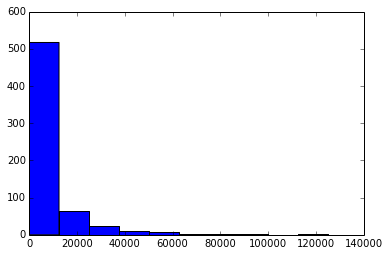

In [29]:
from matplotlib import pyplot as plt
plt.hist(cared_old_cost)
plt.show()

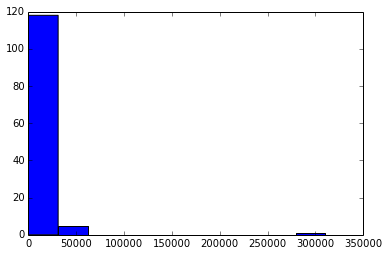

In [30]:
plt.hist(uncared_old_cost)
plt.show()